In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
import keras

In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:

train_path = 'train'
test_path = 'test'

In [ ]:
for folder in  os.listdir(train_path) :
    files = gb.glob(pathname= str( train_path +'//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')


For training data , found 7215 in folder happy
For training data , found 3995 in folder angry
For training data , found 4965 in folder neutral
For training data , found 4830 in folder sad
For training data , found 4097 in folder fear
For training data , found 436 in folder disgust
For training data , found 3171 in folder surprise


In [ ]:
for folder in  os.listdir(test_path) :
    files = gb.glob(pathname= str( test_path +'//' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For testing data , found 1774 in folder happy
For testing data , found 958 in folder angry
For testing data , found 1233 in folder neutral
For testing data , found 1247 in folder sad
For testing data , found 1024 in folder fear
For testing data , found 111 in folder disgust
For testing data , found 831 in folder surprise


In [ ]:
code ={
      'angry':0,
      'disgust': 1,
      'fear': 2,
      'happy': 3,
      'neutral': 4,
      'sad': 5,
      'surprise': 6
      }

def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

In [ ]:
size = []
for folder in  os.listdir(train_path) :
    files = gb.glob(pathname= str( train_path +'//' + folder + '/*.jpg'))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

,count
"(48, 48)",28709


In [ ]:
size = []
for folder in  os.listdir(test_path) :
    files = gb.glob(pathname= str( test_path +'//' + folder + '/*.jpg'))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

,count
"(48, 48)",7178


In [ ]:
def image_preprocessing(img) :
    img = cv2.resize(img,(48,48))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    denoised = cv2.GaussianBlur(equalized, (5, 5), 0)
    normalized = denoised / 255.0
    normalized = np.expand_dims(normalized, axis=-1)
    return normalized

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


def augment_image(image, num_samples=100):
    augmented_images = []

    image = np.expand_dims(image, axis=0)

    for _ in range(num_samples):
        augmented_image = datagen.random_transform(image[0])
        augmented_images.append(augmented_image)

    return augmented_images

def augment_minority_class(X, y, target_class, num_samples):
    augmented_images = []
    augmented_labels = []

    minority_class_indices = [i for i, label in enumerate(y) if label == target_class]

    for idx in minority_class_indices:
        image = X[idx]
        augmented_images.extend(augment_image(image, num_samples))
        augmented_labels.extend([target_class] * num_samples)
    return augmented_images, augmented_labels

In [ ]:
X_train = []
y_train = []
for folder in  os.listdir(train_path) :
    files = gb.glob(pathname= str( train_path +'//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image = image_preprocessing(image)
        X_train.append(image)
        y_train.append(code[folder])
size = []
for image in  X_train :
    size.append(image.shape)
pd.Series(size).value_counts()


,count
"(48, 48, 1)",28709


In [ ]:
augmented_images, augmented_labels = augment_minority_class(X_train, y_train, target_class=code["fear"], num_samples=2)
X_train.extend(augmented_images)
y_train.extend(augmented_labels)
augmented_images, augmented_labels = augment_minority_class(X_train, y_train, target_class=code["angry"], num_samples=2)
X_train.extend(augmented_images)
y_train.extend(augmented_labels)
augmented_images, augmented_labels = augment_minority_class(X_train, y_train, target_class=code["neutral"], num_samples=2)
X_train.extend(augmented_images)
y_train.extend(augmented_labels)
augmented_images, augmented_labels = augment_minority_class(X_train, y_train, target_class=code["sad"], num_samples=2)
X_train.extend(augmented_images)
y_train.extend(augmented_labels)
augmented_images, augmented_labels = augment_minority_class(X_train, y_train, target_class=code["surprise"], num_samples=2)
X_train.extend(augmented_images)
y_train.extend(augmented_labels)
augmented_images, augmented_labels = augment_minority_class(X_train, y_train, target_class=code["happy"], num_samples=1)
X_train.extend(augmented_images)
y_train.extend(augmented_labels)



In [ ]:
print(f'we have {len(X_train)} items in X_train')

we have 78040 items in X_train


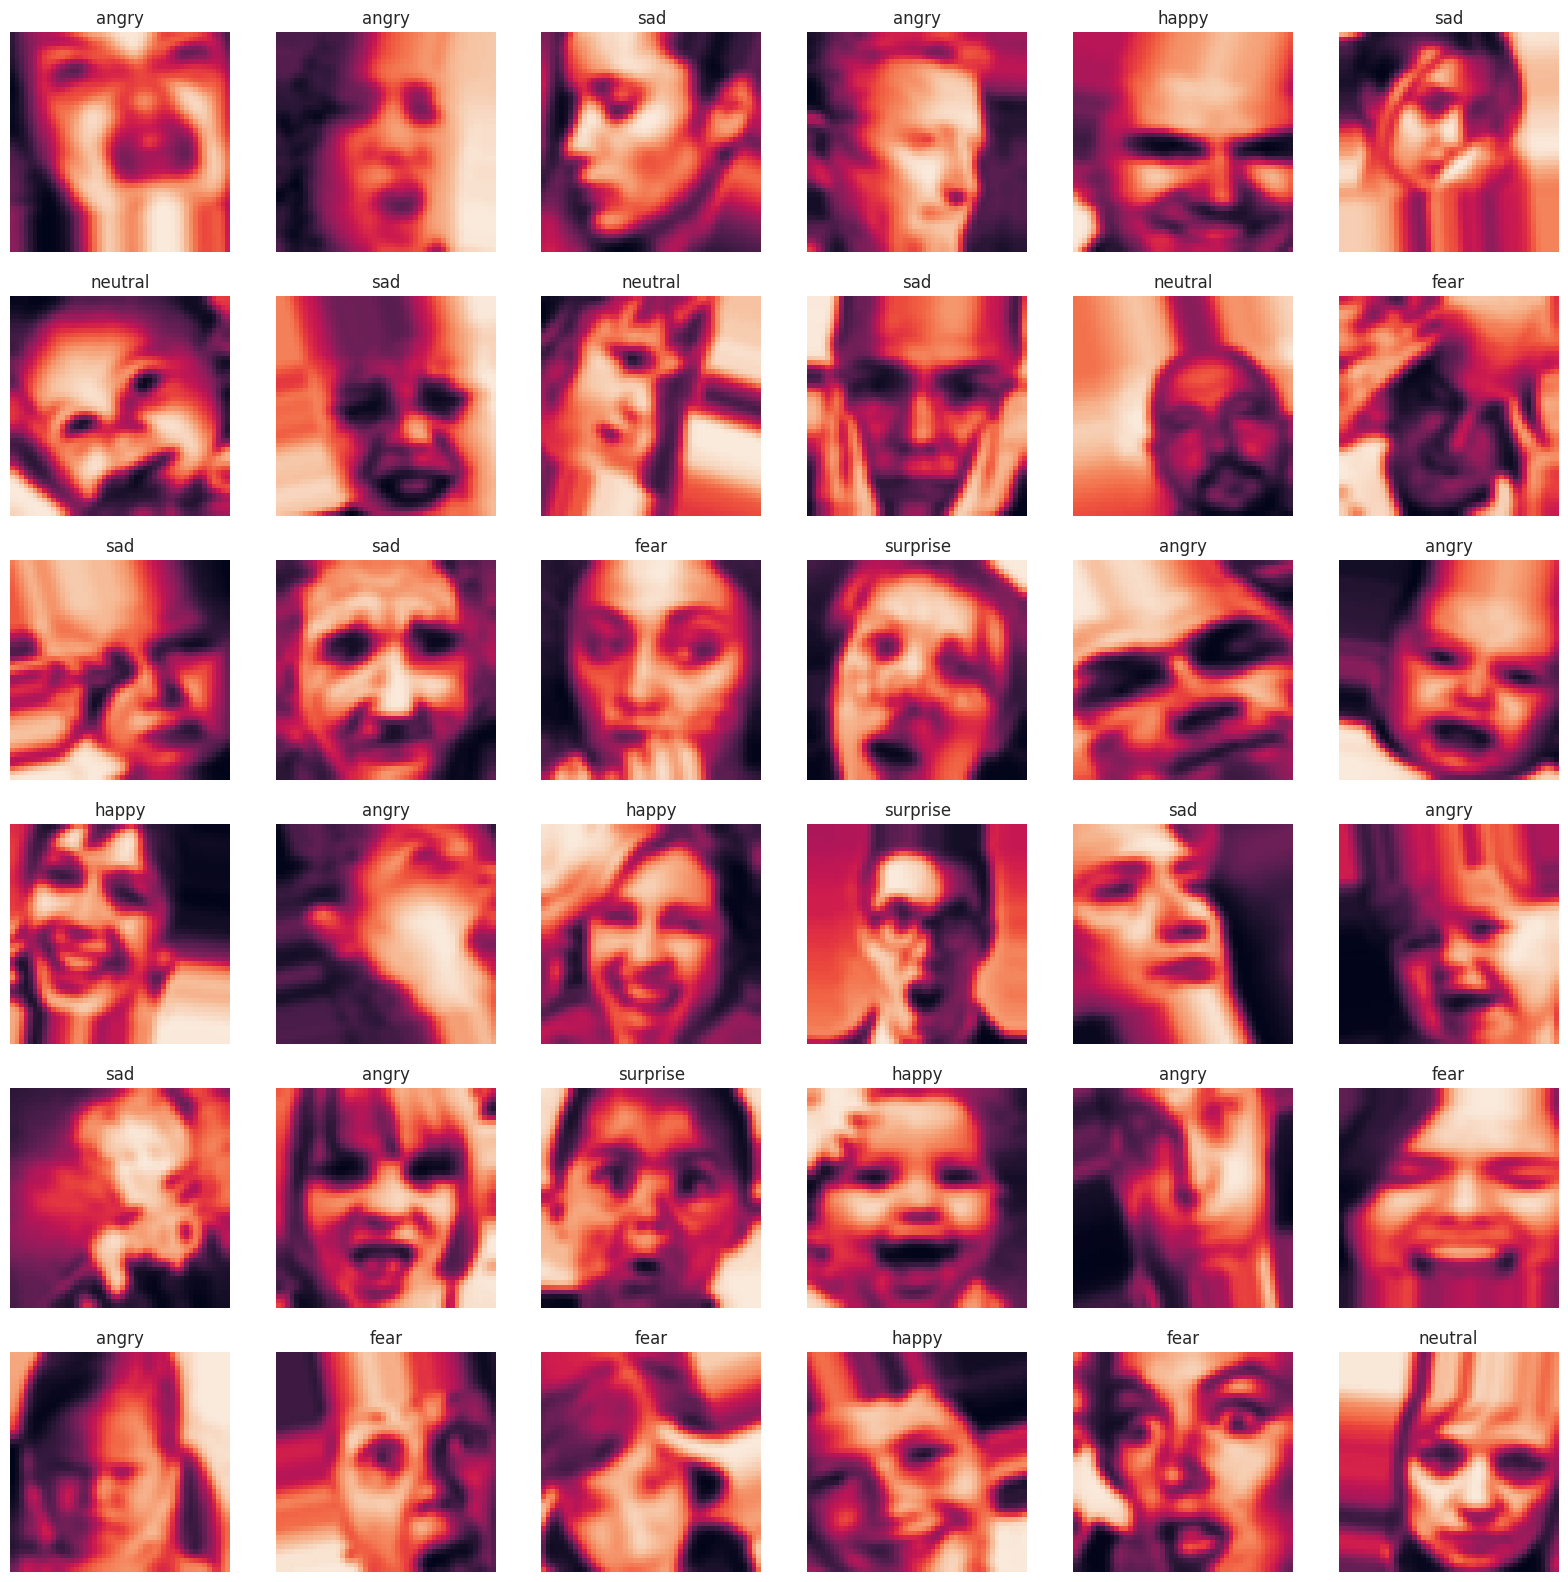

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(getcode(y_train[i]))
plt.show()

In [ ]:
X_test = []
y_test = []
for folder in  os.listdir(test_path) :
    files = gb.glob(pathname= str( test_path +'//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image = image_preprocessing(image)
        X_test.append(image)
        y_test.append(code[folder])

In [ ]:
print(f'we have {len(X_test)} items in X_test')

we have 7178 items in X_test


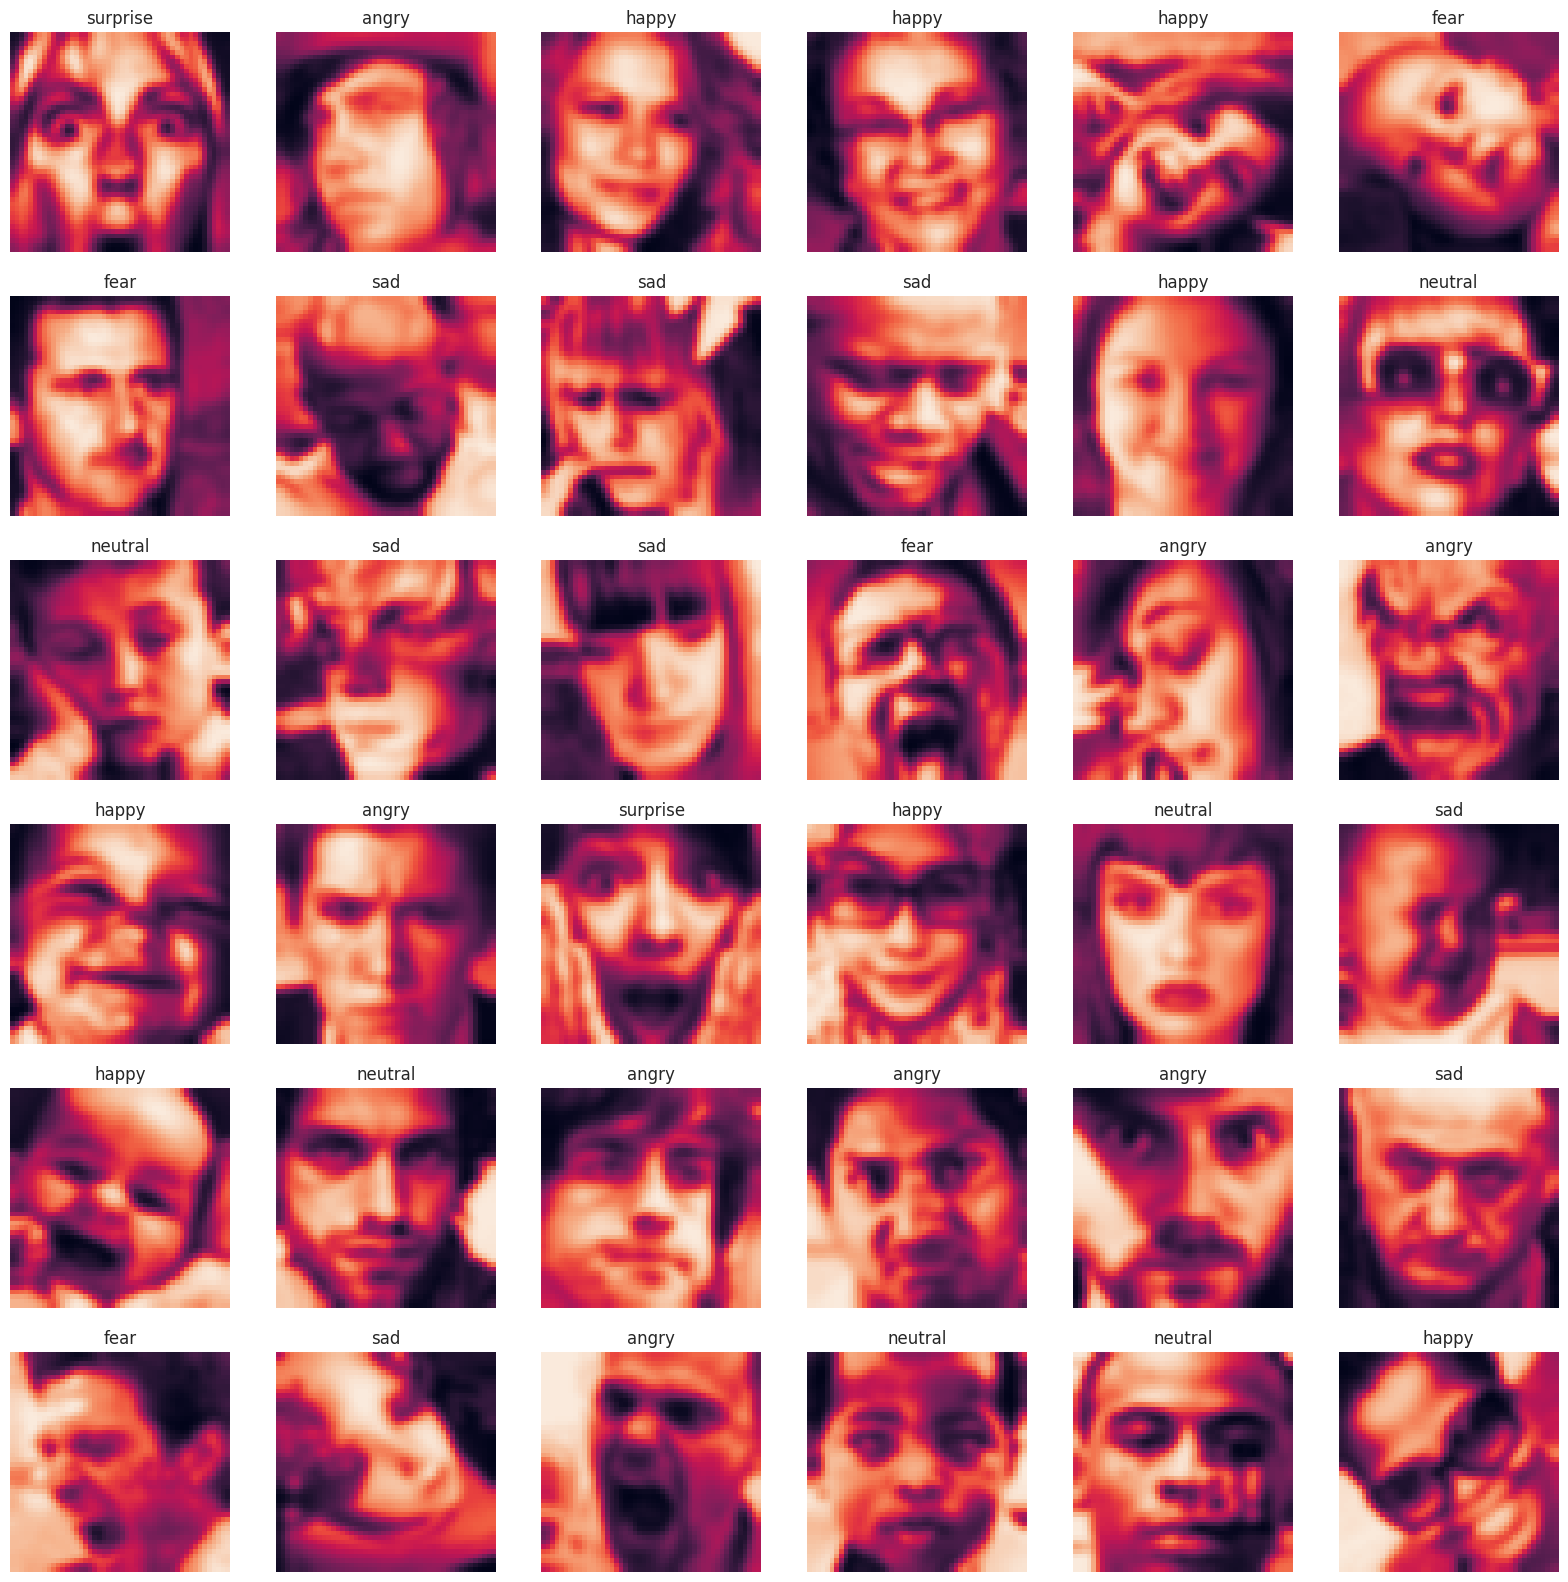

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(getcode(y_test[i]))
plt.show()

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (78040, 48, 48, 1)
X_test shape  is (7178, 48, 48, 1)
y_train shape  is (78040,)
y_test shape  is (7178,)


In [ ]:

KerasModel = keras.models.Sequential([
    keras.layers.Input(shape=(48, 48, 1)),
    keras.layers.Conv2D(200, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(150, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(120, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(80, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(50, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(7, activation='softmax')

])


In [ ]:
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 200)         │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 200)         │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 150)         │         270,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 44, 44, 150)         │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 120)         │         162,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 120)         │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 80)          │          86,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 80)          │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 50)          │          36,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         384,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 120)                 │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          12,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,0

 Total params: 961,907 (3.67 MB)

 Trainable params: 960,167 (3.66 MB)

 Non-trainable params: 1,740 (6.80 KB)

None


In [ ]:
#check point
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='model_weights.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10 ,restore_best_weights=True)

In [ ]:
epochs = 50
ThisModel = KerasModel.fit(X_train, y_train, epochs=epochs,batch_size=32, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/50
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2132 - loss: 2.0863
Epoch 1: val_accuracy improved from -inf to 0.41404, saving model to model_weights.keras
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 120s 43ms/step - accuracy: 0.2132 - loss: 2.0862 - val_accuracy: 0.4140 - val_loss: 1.5138
Epoch 2/50
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3402 - loss: 1.6117
Epoch 2: val_accuracy improved from 0.41404 to 0.43201, saving model to model_weights.keras
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 109s 34ms/step - accuracy: 0.3402 - loss: 1.6116 - val_accuracy: 0.4320 - val_loss: 1.4687
Epoch 3/50
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4213 - loss: 1.4624
Epoch 3: val_accuracy improved from 0.43201 to 0.49582, saving model to model_weights.keras
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 86s 35ms/step - accuracy: 0.4213 - loss: 1.4624 - val_accuracy: 0.4958 - val_loss: 1.3051
Epoch 4/50
2438/2439 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4738 - loss: 1.3545
Epoch 

In [ ]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6616 - loss: 2.0227
Test Loss is 2.4421868324279785
Test Accuracy is 0.5816383361816406


In [ ]:
y_pred = KerasModel.predict(X_test)

print('Prediction Shape is {}'.format(y_pred.shape))

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Prediction Shape is (7178, 7)


In [ ]:
KerasModel.save('my_model.keras')


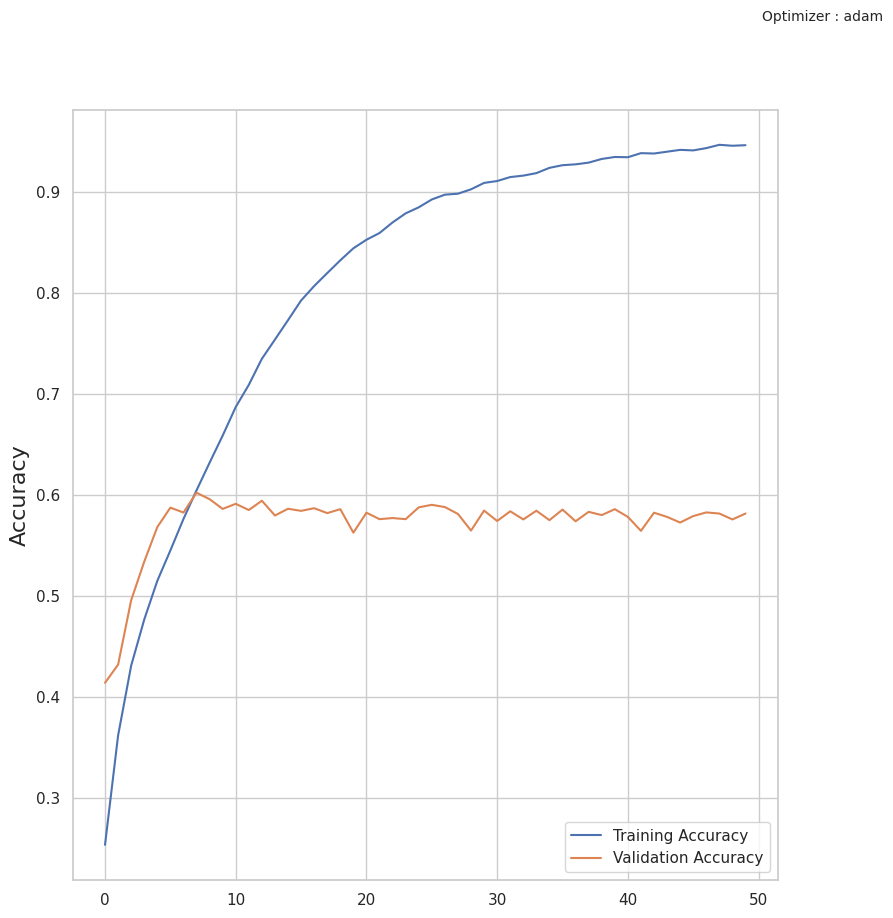

In [ ]:
# plot train and validation acurecy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(ThisModel.history['accuracy'], label='Training Accuracy')
plt.plot(ThisModel.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

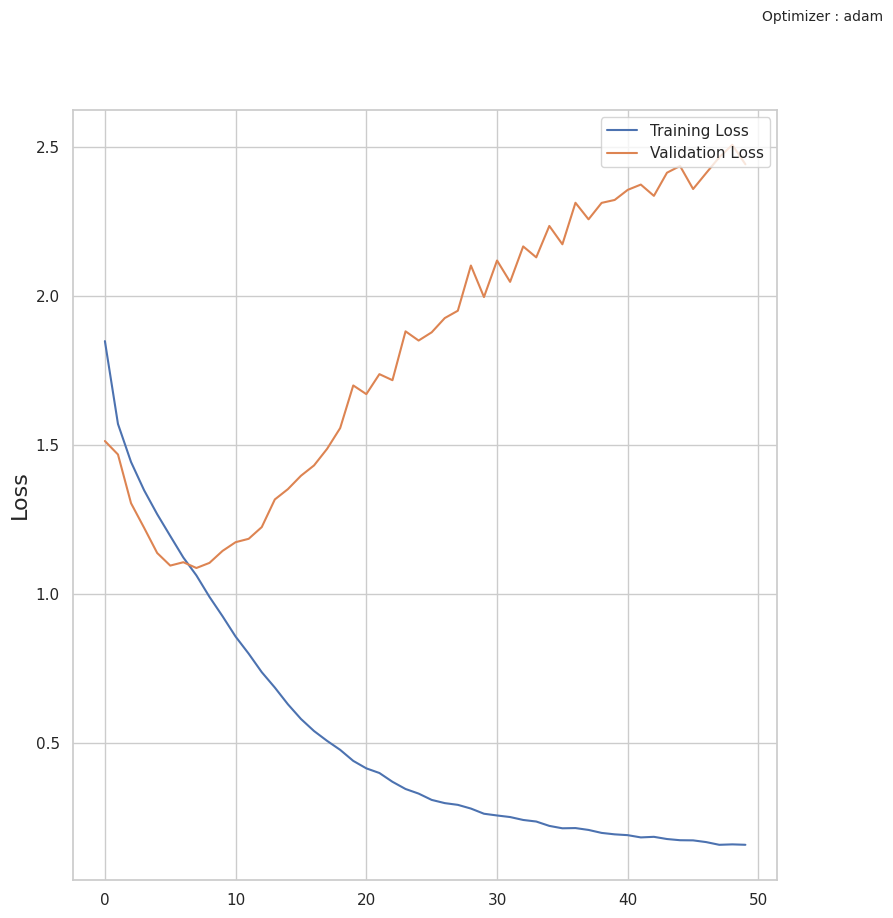

In [ ]:
# plot train and loss
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(ThisModel.history['loss'], label='Training Loss')
plt.plot(ThisModel.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

NameError: name 'history' is not defined

In [ ]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')